In [1]:
import os
import itertools
import numpy                as np
import pandas               as pd
import seaborn              as sns
import matplotlib.pyplot    as plt
import matplotlib.ticker    as mtick

import utils.synthetic_gen  as sg

from   matplotlib.lines     import Line2D
from   matplotlib.patches   import Patch, Rectangle
from   matplotlib.gridspec  import GridSpec
from   scipy.stats          import pearsonr, spearmanr, gaussian_kde

from   model.user_item_dataset          import UserItemDataset
from   utils.recwalk_funcs              import create_recwalk_model

In [2]:
def calculate_matrix_Q(P, gamma=0.15):
    return gamma*np.linalg.inv((np.identity(P.shape[0]) - (1-gamma)*P))

In [3]:
# PLOTTING CONFIGURATIONS
# enable inline plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # set format to svg for better resolution
# sns.set_theme() # apply default theme in seaborn

In [4]:
# TODO:
#    - Make temporary cystomizing using 'plt.style.context()'
# pdf formatting parameters
plt.rc('font', size=18)
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('legend', title_fontsize=20)
plt.rc('lines', linewidth=3)
plt.rc('lines', markersize=15)

In [3]:
plt.rcdefaults()

## Read items in pandas

In [5]:
# Read all genres
with open('../datasets/ml-100k/u.genre') as f:
    genres = [l.split('|')[0] for l in f.readlines()]

# Make list with column names
cols = ['id', 'title', 'date', 'garbage', 'url'] + genres
# Read items file in pandas
items_df = pd.read_csv('../datasets/ml-100k/u.item', sep='|', encoding='ISO-8859-1', names=cols, header=None)
items_df.drop(['garbage', 'url'], axis=1, inplace=True)

# Keep only Action and Romance
items_df = items_df.loc[(items_df['Action'] == 1) | (items_df['Romance'] == 1)]

## Dataset loading

In [6]:
# Load dataset
my_dataset = UserItemDataset()
my_dataset.load_data(info_filepath='../datasets/ml-100k/u.info',
                     users_filepath='../datasets/ml-100k/u.user',
                     items_filepath='../datasets/ml-100k/u.item',
                     genres_filepath='../datasets/ml-100k/u.genre',
                     ratings_filepath='../datasets/ml-100k/u.data')

genres_of_interest = ['Action', 'Romance']

user_original_ids, item_original_ids, R = my_dataset.filter_interactions_by_genre(genres_of_interest,
                                                                                  exclusive=True)

users_num, items_num = R.shape[0], R.shape[1]

# Seperate item group mapped ids for group 0 and group 1
item_group_mapped_ids_0, item_group_mapped_ids_1 = [], []
for i in range(item_original_ids.shape[0]):
    if my_dataset.is_genre(item_original_ids[i], genres_of_interest[0]):
        item_group_mapped_ids_0.append(i)
    else:
        item_group_mapped_ids_1.append(i)

# Transform to numpy arrays
item_group_mapped_ids_0, item_group_mapped_ids_1 = np.array(item_group_mapped_ids_0), np.array(item_group_mapped_ids_1)

male_mapped_ids = np.array([i for i in range(users_num) if my_dataset.is_male(user_original_ids[i])])
female_mapped_ids = np.array([i for i in range(users_num) if not my_dataset.is_male(user_original_ids[i])])

# Individual-level explanations

In [55]:
def plot_avg(exp_dir,
             exp_filenames,
             output_filename,
             item_group, # Used to decide which category we increase (0 or 1)
             calculation_type, # Supported: 'increase', 'fraction'
             params_dict,
             error_type = None,
             output_format='png'):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)
    for file_ind in range(len(exp_filenames)):
        with open(f"{exp_dir}/{exp_filenames[file_ind]}.tsv") as f:
            for i in range(5): f.readline() # Skip header lines

            lines = f.readlines()
            
            user_ids = np.array([int(lines[i]) for i in range(0, len(lines), 4)])
            p_u_I_0_all = [[float(j) for j in lines[i].split()] for i in range(1, len(lines), 4)]
            p_u_I_1_all = [[float(j) for j in lines[i].split()] for i in range(2, len(lines), 4)]
            item_ids_removed = [[int(j) for j in lines[i].split()] for i in range(3, len(lines), 4)]
            
        if calculation_type == 'increase':
#             scores_all = p_u_I_0_all if item_group == 0 else p_u_I_1_all
            
#             y_values_all = [[(cur_s - scores[0])/scores[0] for cur_s in scores] for scores in scores_all]
            numerator_all, denominator_all = (p_u_I_0_all, p_u_I_1_all) if item_group == 0 else (p_u_I_1_all, p_u_I_0_all)
        
            y_values_all = [[(numerator_all[i][j] - numerator_all[i][0])/denominator_all[i][j]
                                                         for j in range(len(numerator_all[i]))]
                             for i in range(len(numerator_all))]
        elif calculation_type == 'fraction':
            numerator_all, denominator_all = (p_u_I_0_all, p_u_I_1_all) if item_group == 0 else (p_u_I_1_all, p_u_I_0_all)
                
            y_values_all = [[numerator_all[i][j]/denominator_all[i][j] for j in range(len(numerator_all[i]))]
                             for i in range(len(numerator_all))]
        else:
            raise NotImplementedError("So far, the supported values for 'calculation_type' are:\n" +
                                      "\t-'increase'" +
                                      "\t-'fraction'")

        # Make lists equal in length, duplicating last value
        max_len = max([len(x) for x in y_values_all])
        for i in range(len(y_values_all)):
            if len(y_values_all[i]) <  max_len:
                y_values_all[i] += [y_values_all[i][-1]]*(max_len - len(y_values_all[i]))
                
        if 'nbs_limit' in params_dict:
            for i in range(len(y_values_all)): y_values_all[i] = y_values_all[i][:params_dict['nbs_limit']]
                
        y_values_all = np.array([np.array(x) for x in y_values_all])
        y_values_all_avg = np.mean(y_values_all, axis=0)
        
        if calculation_type == 'fraction':
            y_values_all = y_values_all[:, :params_dict['limit']]
            y_values_all_avg = y_values_all_avg[:params_dict['limit']]
            
            ax.axhline(y=params_dict['fraction_target'],
                       linestyle='dashed')
        
        ###### PLOTS ######
        ax.plot(np.arange(y_values_all_avg.shape[0]),
                y_values_all_avg,
                color=params_dict['colors'][file_ind],
                marker=params_dict['markers'][file_ind],
                markevery=y_values_all_avg.shape[0]//10)
#                 markersize=15)

        if error_type != None:
            if error_type == 'se': # Standard Error
                error = np.std(y_values_all, axis=0)/(y_values_all.shape[0])**(1/2)
                error_label = 'Standard Error'
            elif error_type == 'var': # Variance
                error = np.var(y_values_all, axis=0)
                error_label = 'Variance'
            else:
                raise NotImplementedError("Available error types:\n" +
                                         "'se': Standard Error\n" +
                                         "'var': Variance")
            # Plot error
            ax.fill_between(x=np.arange(y_values_all_avg.shape[0]),
                            y1=(y_values_all_avg + error),
                            y2=(y_values_all_avg - error),
                            alpha=0.2)
        
        if calculation_type == 'increase':
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
        
        ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
    
    legend_shapes = [Line2D([0,1],[0,1], color=params_dict['colors'][i], marker=params_dict['markers'][i])
                     for i in range(len(exp_filenames))]
    legend_shapes += [Patch(label=error_label, color='slategray', alpha=0.8)]
    legend_texts = params_dict['labels']
    legend_texts += [error_label]
    ax.legend(legend_shapes, legend_texts, loc='lower right')
    
    plt.xlabel("Explanation Size")
    if calculation_type == 'increase':
        plt.ylabel('Average Relative Increase in ' + r'$B(I|u)$')
    else:
        plt.ylabel(r'Average $B(I|u)$')
        
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{output_filename}.{output_format}")

## Experiment 1 - Plot average PPR

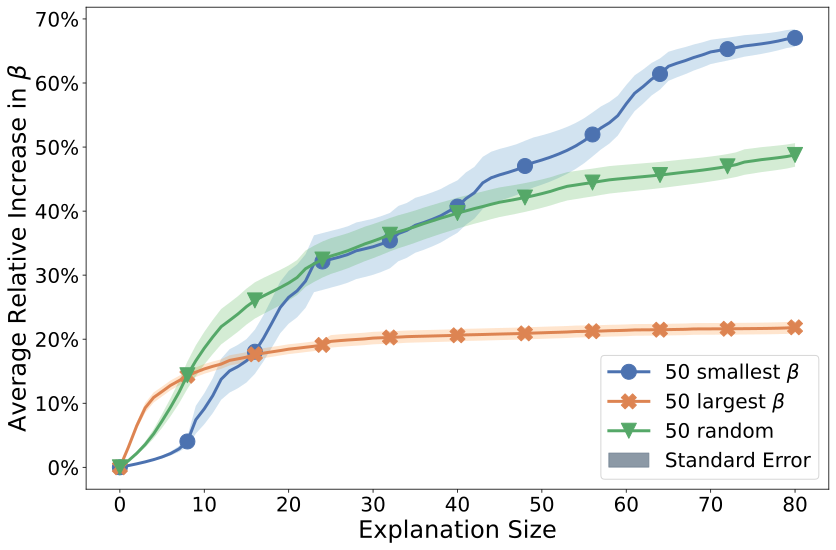

In [41]:
exp_dir = './output/full/individual_user_side/exp1'
exp_filenames = ['exp1_50_smallest_b',
                 'exp1_50_largest_b',
                 'exp1_50_random']
output_dir = './plots/full/individual_user_side/exp1'
error_type = 'se'
output_filename = f'exp1_avg_{error_type}'

sample_size = exp_filenames[0].split('_')[1]

params_dict = {'suptitle_str': 'Experiment 1 - Average PPR increase to unseen per edge removal',
               'title_str': "Real data\n" + f"Number of users: {sample_size}" + "\n" + r"$I_{0}$ = Romance",
               'colors' : sns.color_palette('deep'),
               'labels' : [f"{sample_size} smallest " + r"$\beta$",
                         f"{sample_size} largest " + r"$\beta$",
                         f"{sample_size} random"],
               'markers' : ['o', 'X', 'v'],
               'nbs_limit' : 81}

# Make plot
plot_avg(exp_dir          = exp_dir,
         exp_filenames    = exp_filenames,
         output_filename  = output_filename,
         item_group       = 1,
         calculation_type = 'increase',
         params_dict      = params_dict,
         error_type       = error_type,
         output_format    = 'pdf')

## Experiment 2 - Algorithms comparison

* Delta with **multiple** edges
* Delta **recalculation**
* Delta calculation **once**

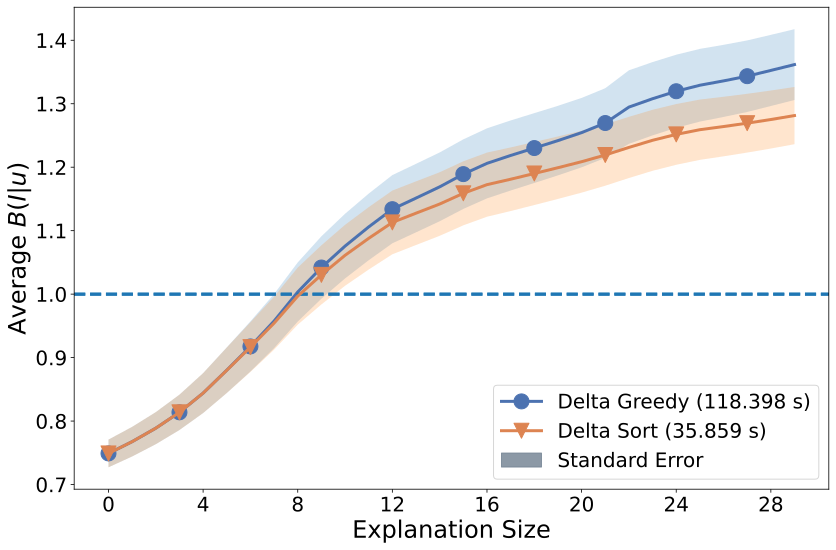

In [49]:
exp_dir = './output/full/individual_user_side/exp2'
exp_filenames = ['exp2_50_random_multiple',
#                  'exp2_50_random_recalculation',
                 'exp2_50_random_delta_once']
output_dir = './plots/full/individual_user_side/exp2'
error_type = 'se'
output_filename = f'exp2_algo_comparison_{error_type}'

sample_size = exp_filenames[0].split('_')[1]

params_dict = {'suptitle_str': 'Experiment 2 - Algorithms comparison',
             'title_str': "Real data\n" + f"Number of users: {sample_size}" + "\n" + r"$I_{0}$ = Romance",
             'colors' : sns.color_palette('deep'),
             'labels' : ['Delta Greedy (118.398 s)',
#                          'Recalculation (3,194.382 s)',
                         'Delta Sort (35.859 s)'],
             'markers' : ['o', 'v'],
             'limit' : 30,
             'fraction_target' : 1}

# Make plot
plot_avg(exp_dir          = exp_dir,
         exp_filenames    = exp_filenames,
         output_filename  = output_filename,
         item_group       = 1,
         calculation_type = 'fraction',
         params_dict      = params_dict,
         error_type       = error_type,
         output_format    = 'pdf')

## Experiment 3

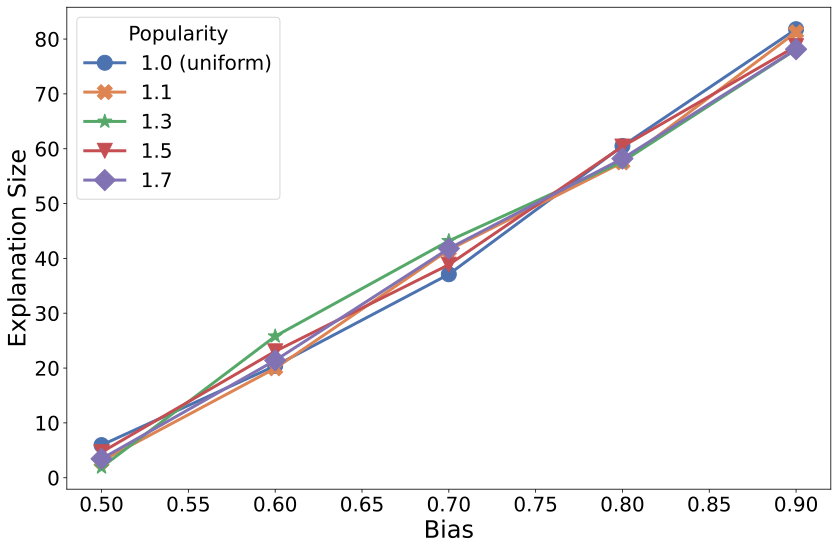

In [146]:
# exp_dir = './output/full/individual_user_side/exp3/all'
exp_dir = './output/full/individual_user_side/exp3/males'
output_dir = './plots/full/individual_user_side/exp3'
output_filename = 'exp3_s_bias_expl_males'
output_format = 'pdf'

item_group = 1
fairness_value = 1

markers = ['o', 'X', '*', 'v', 'D']
colors = sns.color_palette('deep')

bias, popularity, avg_expl_size = [], [], []
for filename in os.listdir(exp_dir):
    cur_b, cur_p = float(filename.split('_')[2]), float(filename.split('_')[4])
    bias, popularity = bias + [cur_b], popularity + [cur_p]
    
    with open(os.path.join(exp_dir, filename)) as f:
        for i in range(5): f.readline() # Skip header lines
            
        lines = f.readlines()
        user_ids = np.array([int(lines[i]) for i in range(0, len(lines), 4)])
        p_u_I_0_all = np.array([np.array([float(j) for j in lines[i].split()]) for i in range(1, len(lines), 4)])
        p_u_I_1_all = np.array([np.array([float(j) for j in lines[i].split()]) for i in range(2, len(lines), 4)])
        item_ids = np.array([np.array([int(j) for j in lines[i].split()]) for i in range(3, len(lines), 4)])
        
    num, denom = (p_u_I_0_all, p_u_I_1_all) if item_group == 0 else (p_u_I_1_all, p_u_I_0_all)
    beta_all = num/denom
    
    avg_expl_size += [np.mean(np.argmax(beta_all > fairness_value, axis=1))]

bias, popularity, avg_expl_size = np.array(bias), np.array(popularity), np.array(avg_expl_size)

# Plot bias
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)

un_pop = np.unique(popularity)
for i in range(un_pop.shape[0]):
    inds = np.where(popularity == un_pop[i])[0]
    
    ax.plot(bias[inds],
            avg_expl_size[inds],
            label=f"{str(un_pop[i]) + ' (uniform)' if un_pop[i] == 1 else str(un_pop[i])}",
            color=colors[i],
            marker=markers[i])
    
ax.set_xlabel('Bias')
ax.set_ylabel(r'Explanation Size')

# ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.legend(title='Popularity')

plt.tight_layout()
plt.savefig(f'{output_dir}/{output_filename}.{output_format}')

#### Bias plot

In [12]:
def create_bias_plot(bias_values,
                     popularity_values,
                     ppr_increase_arr,
                     output_path,
                     output_filename,
                     in_percentage,
                     plot_params_dict,
                     output_format='png'):
    
    markers = ['.', 's', 'x', '|', 'v', '*']
    # Pick seaborn color palette
    colors = sns.color_palette('colorblind')[0:len(popularity_values)]
    
    # x-axis: bias
    # y-axis: PPR increase
    # Values: 1 plot for every popularity value
    fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize = (12, 8), dpi=120)
    
    for i in range(len(popularity_values)):
        axs.plot(bias_values,
                 ppr_increase_arr[:, i],
                 label=f"{'uniform' if popularity_values[i]==1 else popularity_values[i]}",
                 marker=markers[i],
                 color=colors[i])
        
    if in_percentage:
        # Format y-axis with percentages
        axs.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    
    if output_format != 'pdf':
        plt.suptitle(plot_params_dict['suptitle'])
        plt.title(plot_params_dict['title'])
    plt.xlabel("Bias")
    plt.ylabel(plot_params_dict['ylabel'])
    plt.legend(title='Popularity')
    plt.tight_layout()

    plt.savefig(f"{output_path}/{output_filename}.{output_format}")

#### Popularity plot

In [13]:
def create_popularity_plot(bias_values,
                           popularity_values,
                           ppr_increase_arr,
                           output_path,
                           output_filename,
                           in_percentage,
                           plot_params_dict,
                           output_format='png'):
    
    markers = ['.', 's', 'x', '|', 'v']
    # Pick seaborn color palette
    colors = sns.color_palette('colorblind')[0:len(bias_values)]
    
    # x-axis: popularity
    # y-axis: PPR increase
    # Values: 1 plot for every bias value
    fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize = (12, 8), dpi=120)
    
    for i in range(len(bias_values)):
        axs.plot(popularity_values,
                 ppr_increase_arr[i, :],
                 label=f"{bias_values[i]}",
                 marker=markers[i],
                 color=colors[i])
    
    if in_percentage:
        # Format y-axis with percentages
        axs.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    
    if output_format != 'pdf':
        plt.suptitle(plot_params_dict['suptitle'])
        plt.title(plot_params_dict['title'])
    plt.xlabel("Popularity")
    plt.ylabel(plot_params_dict['ylabel'])
    plt.legend(title='Bias')
    plt.tight_layout()

    plt.savefig(f"{output_path}/{output_filename}.{output_format}")

## Experiment 4 - Correlation between delta and popularity

Outliers (positive) cnt: 2
p-value < 0.05: 109/199
Outliers (positive) cnt: 0
p-value < 0.05: 200/200


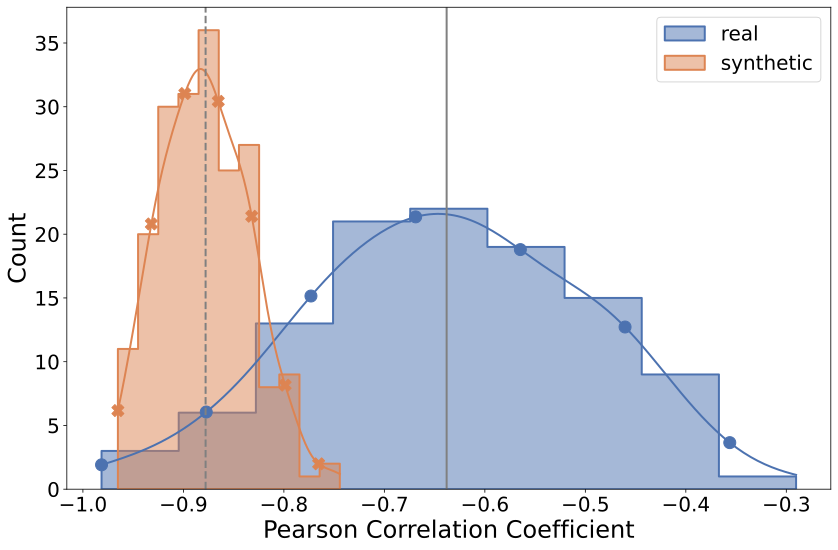

In [7]:
############ Parameters
exp_dir = './output/full/individual_user_side/exp4'
output_dir = './plots/full/individual_user_side/exp4'
output_format = 'png'

exp_filenames = ['exp4_200_random', 'exp4_200_random_synth_0.7_b_1.3_p']
dataset_type = ['r', 's']

synth_dir_path = '../datasets/synthetic'
synth_filename = 'synth_0.7_b_1.3_p'
# exp_filename = 'exp4_200_random_synth_0.7_b_1.3_p'

hatches = ['/', 'o']
linestyles = ['solid', 'dashed']
markers = ['o', 'X']
color_p = sns.color_palette('deep')
colors = [color_p[0], color_p[1]]
############
correlation_all = []

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)
for exp_filename_ind in range(len(exp_filenames)):
    # Read experiment file
    with open(f"{exp_dir}/{exp_filenames[exp_filename_ind]}.tsv") as f:
        for i in range(5): f.readline()

        lines = f.readlines()

        user_ids = [int(lines[i]) for i in range(0, len(lines), 4)]
        ppr_initial_all = [float(lines[i]) for i in range(1, len(lines), 4)]
        deltas_all = [np.array([float(j) for j in lines[i].split()]) for i in range(2, len(lines), 4)]
        item_ids_all = [np.array([int(j) for j in lines[i].split()]) for i in range(3, len(lines), 4)]

    # Keep only the positive deltas and corresponding items
    for i in range(len(deltas_all)):
        pos_inds = np.where(deltas_all[i] > 0)[0]

        deltas_all[i] = deltas_all[i][pos_inds]
        item_ids_all[i] = item_ids_all[i][pos_inds]

    # Load corresponding interaction matrix
    if dataset_type[exp_filename_ind] == 'r':
        # Load dataset
        my_dataset = UserItemDataset()
        my_dataset.load_data(info_filepath='../datasets/ml-100k/u.info',
                             users_filepath='../datasets/ml-100k/u.user',
                             items_filepath='../datasets/ml-100k/u.item',
                             genres_filepath='../datasets/ml-100k/u.genre',
                             ratings_filepath='../datasets/ml-100k/u.data')

        genres_of_interest = ['Action', 'Romance']
        user_original_ids, item_original_ids, R = my_dataset.filter_interactions_by_genre(genres_of_interest,
                                                                                          exclusive=True)
    else:
        # Read synthetic dataset
        info_dict, R = sg.read_graph(synth_dir_path, synth_filename)
        users_num, items_num = info_dict['num_users'], info_dict['num_items']
        user_original_ids, item_original_ids = np.arange(users_num), np.arange(items_num)

    ##### Calculate correlation
    correlations = []
    outliers_cnt = 0
    for i in range(len(user_ids)):
        if len(deltas_all[i]) < 2: continue
        pearson_res = pearsonr(deltas_all[i],
                               [np.count_nonzero(R[:, np.where(item_original_ids == j)[0][0]])/R.shape[0]
                                for j in item_ids_all[i]])

        if pearson_res.pvalue > 0.05: continue
        if pearson_res.statistic > 0: outliers_cnt += 1; continue

        correlations.append(pearson_res.statistic)

    print(f"Outliers (positive) cnt: {outliers_cnt}")
    print(f"p-value < 0.05: {len(correlations)}/{len(user_ids)}")
    
    hist_cur = sns.histplot(data=correlations,
                 element='step',
                 linewidth=2,
                 color=list(colors[exp_filename_ind]) + [0.5],
                 ec=colors[exp_filename_ind],
                 kde=True,
                 line_kws={'lw': 2, 'marker': markers[exp_filename_ind],
                           'markevery': 30,
                           'markersize': 12})
                      
    # Plot a vertical line on the mean
    ax.axvline(x=np.mean(np.array(correlations)),
               ymin=0,
               ymax=1,
               color='gray',
               linewidth=2,
               linestyle=linestyles[exp_filename_ind])
    
    correlation_all.append(correlations)

ax.set_xlabel('Pearson Correlation Coefficient')
ax.set_ylabel('Count')

# Set up legend
patches = []
patches += [Rectangle((0,0),1,1,color=(list(colors[i]) + [0.5]),lw=2,ec=colors[i]) for i in range(len(colors))]
# patches += [Line2D([0,1],[0,1], c='gray', ls=linestyles[i], lw=2) for i in range(len(colors))]
# patches += [Line2D([0,1],[0,1], c=colors[i], marker=markers[i], markersize=12, lw=2) for i in range(len(colors))]
legend_texts = ['real', 'synthetic']
#                 f'mean (real): {round(np.mean(np.array(correlation_all[0])),3)}',
#                 f'mean (synthetic): {round(np.mean(np.array(correlation_all[1])), 3)}',
#                 'KDE (real)',
#                 'KDE (synthetic)']
plt.legend(patches, legend_texts)

plt.tight_layout()
# plt.savefig(f"{output_dir}/{exp_filenames[exp_filename_ind]}_delta_pop_co_2.{output_format}")
plt.savefig(f"{output_dir}/exp4_delta_pop_co_combined.{output_format}")

## Experiment 5: Correlation between rank of removal and popularity

Outliers (positive) cnt: 1
p-value < 0.05: 70/200
Outliers (positive) cnt: 0
p-value < 0.05: 57/200


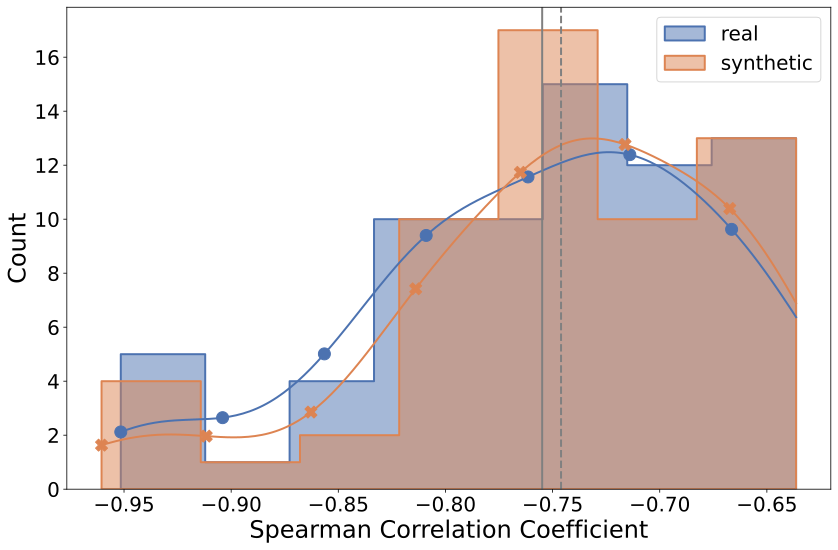

In [8]:
############ Parameters
exp_dir = './output/full/individual_user_side/exp5'
output_dir = './plots/full/individual_user_side/exp5'
output_format = 'png'

exp_filenames = ['exp5_200_random_best_10', 'exp5_200_random_best_10_synth_0.7_b_1.3_p']
dataset_type = ['r', 's']

synth_dir_path = '../datasets/synthetic'
synth_filename = 'synth_0.7_b_1.3_p'

hatches = ['/', 'o']
linestyles = ['solid', 'dashed']
markers = ['o', 'X']
color_p = sns.color_palette('deep')
colors = [color_p[0], color_p[1]]
############
correlation_all = []

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)
for exp_filename_ind in range(len(exp_filenames)):
    with open(f"{exp_dir}/{exp_filenames[exp_filename_ind]}.tsv") as f:
        for i in range(5): f.readline() # Skip header lines

        lines = f.readlines()
        item_ids_removed = [[int(j) for j in lines[i].split()] for i in range(3, len(lines), 4)]

    # Load corresponding interaction matrix
    if dataset_type[exp_filename_ind] == 'r':
        # Load dataset
        my_dataset = UserItemDataset()
        my_dataset.load_data(info_filepath='../datasets/ml-100k/u.info',
                             users_filepath='../datasets/ml-100k/u.user',
                             items_filepath='../datasets/ml-100k/u.item',
                             genres_filepath='../datasets/ml-100k/u.genre',
                             ratings_filepath='../datasets/ml-100k/u.data')

        genres_of_interest = ['Action', 'Romance']
        user_original_ids, item_original_ids, R = my_dataset.filter_interactions_by_genre(genres_of_interest,
                                                                                          exclusive=True)
    else:
        # Read synthetic dataset
        info_dict, R = sg.read_graph(synth_dir_path, synth_filename)
        users_num, items_num = info_dict['num_users'], info_dict['num_items']
        user_original_ids, item_original_ids = np.arange(users_num), np.arange(items_num)

    correlations = []
    outliers_cnt = 0
    for i in range(len(item_ids_removed)):
        spearman_res = spearmanr(np.arange(len(item_ids_removed[i]))[::-1],
                                 [np.count_nonzero(R[:, np.where(item_original_ids == j)[0][0]])/R.shape[0]
                                  for j in item_ids_removed[i]]) # TODO: run again

        if spearman_res.pvalue > 0.05: continue # Eliminate unreliable and outliers
        if spearman_res.correlation > 0: outliers_cnt += 1; continue
            
        correlations.append(spearman_res.correlation)

    print(f"Outliers (positive) cnt: {outliers_cnt}")
    print(f"p-value < 0.05: {len(correlations)}/{len(user_ids)}")
    
    sns.histplot(data=correlations,
                 element='step',
                 linewidth=2,
                 color=list(colors[exp_filename_ind]) + [0.5],
                 ec=colors[exp_filename_ind],
                 kde=True,
                 line_kws={'lw': 2, 'marker': markers[exp_filename_ind],
                           'markevery': 30,
                           'markersize': 12})
                      
    # Plot a vertical line on the mean
    ax.axvline(x=np.mean(np.array(correlations)),
               ymin=0,
               ymax=1,
               color='gray',
               linewidth=2,
               linestyle=linestyles[exp_filename_ind])
    
    correlation_all.append(correlations)

ax.set_xlabel('Spearman Correlation Coefficient')
ax.set_ylabel('Count')

# Set up legend
patches = []
patches += [Rectangle((0,0),1,1,color=(list(colors[i]) + [0.5]),lw=2,ec=colors[i]) for i in range(len(colors))]
# patches += [Line2D([0,1],[0,1], c='gray', ls=linestyles[i], lw=2) for i in range(len(colors))]
# patches += [Line2D([0,1],[0,1], c=colors[i], marker=markers[i], markersize=12, lw=2) for i in range(len(colors))]
legend_texts = ['real', 'synthetic']
#                 f'mean (real): {round(np.mean(np.array(correlation_all[0])),3)}',
#                 f'mean (synthetic): {round(np.mean(np.array(correlation_all[1])), 3)}',
#                 'KDE (real)',
#                 'KDE (synthetic)']
plt.legend(patches, legend_texts)

# ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.tight_layout()
# plt.savefig(f"{output_dir}/{exp_filenames[exp_filename_ind]}_rank_pop_co.{output_format}")
plt.savefig(f"{output_dir}/exp5_rank_pop_co_combined.{output_format}")

## Experiment 6

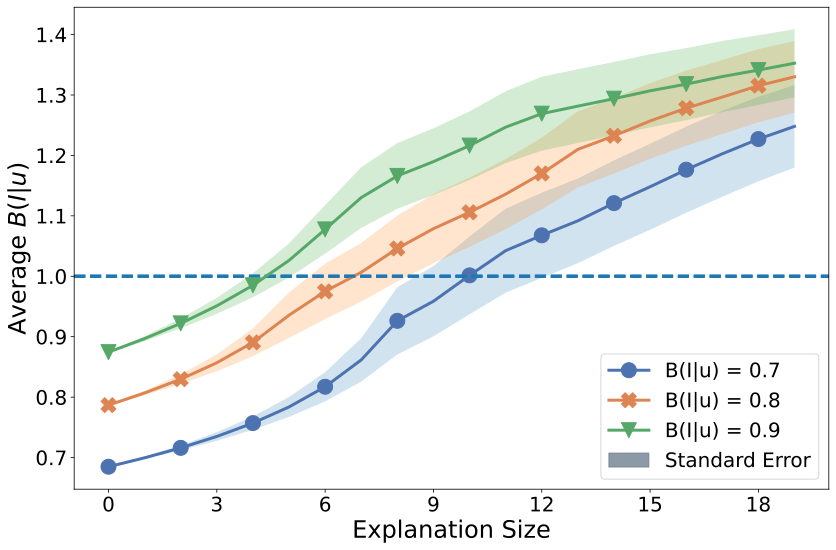

In [58]:
exp_dir = './output/full/individual_user_side/exp6'
# exp_filenames = ['exp6_50_a_1']
exp_filenames = ['exp6_20_b_0.7', 'exp6_20_b_0.8', 'exp6_20_b_0.9']
output_dir = './plots/full/individual_user_side/exp6'
error_type = 'se'
output_filename = f'exp6_avg_{error_type}'

sample_size = exp_filenames[0].split('_')[1]
betas = [float(f.split('_')[-1]) for f in exp_filenames]

params_dict = {'suptitle_str': None,
             'title_str': None,
             'colors' : sns.color_palette('deep'),
             'labels' : [f"B(I|u) = {betas[0]}", f"B(I|u) = {betas[1]}", f"B(I|u) = {betas[2]}"],
             'markers' : ['o', 'X', 'v'],
             'limit': 20,
             'fraction_target': 1}

# Make plot
plot_avg(exp_dir          = exp_dir,
         exp_filenames    = exp_filenames,
         output_filename  = output_filename,
         item_group       = 1,
         calculation_type = 'fraction',
         params_dict      = params_dict,
         error_type       = error_type,
         output_format    = 'pdf')

### Plot explanations with titles

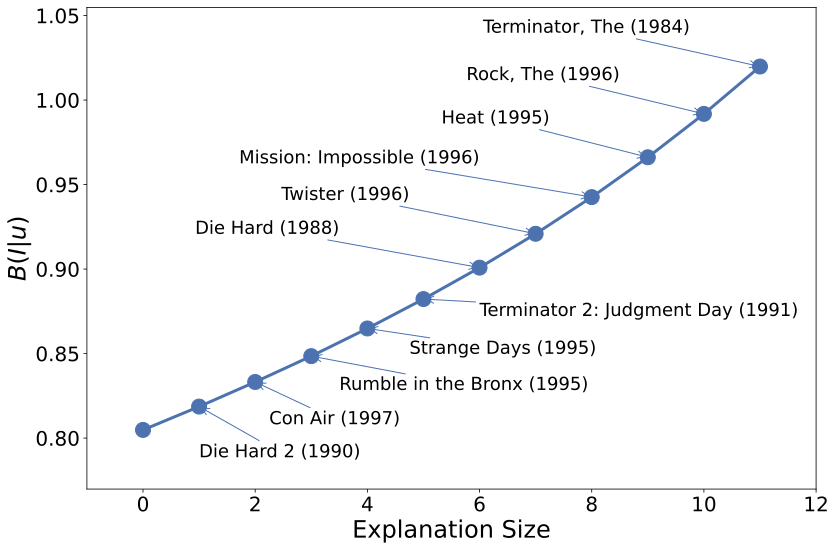

In [61]:
exp_dir = './output/full/individual_user_side/exp6'
exp_filename = 'exp6_50_a_1'
output_dir = './plots/full/individual_user_side/exp6'

output_format = 'pdf'

colors = sns.color_palette('deep')
offset = 0.02 # Annotation offset

with open(f"{exp_dir}/{exp_filename}.tsv") as f:
    for i in range(5): f.readline()
    
    lines = f.readlines()
    user_ids = np.array([int(lines[i]) for i in range(0, len(lines), 4)])
    p_u_I_0_all = [[float(j) for j in lines[i].split()] for i in range(1, len(lines), 4)]
    p_u_I_1_all = [[float(j) for j in lines[i].split()] for i in range(2, len(lines), 4)]
    nbs_removed = [[int(j) for j in lines[i].split()] for i in range(3, len(lines), 4)]

# Read details file in pandas
details_df = pd.read_csv(f'./output/full/individual_user_side/exp6/{exp_filename}_details.tsv', sep='\t')

# Manually select user to plot
user_id_ind = np.where(user_ids == 467)[0][0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)

beta = np.array(p_u_I_1_all[user_id_ind])/np.array(p_u_I_0_all[user_id_ind])

# alpha = details_df[details_df['user_id'] == user_ids[user_id_ind]]['alpha'].values[0]
# for i in range(beta.shape[0]):
#     if beta[i] >= alpha:
#         fairness_ind = i
#         break
fairness_ind = np.argmax(beta > 1)

beta = beta[:(fairness_ind + 1)]
nbs_removed_cur = nbs_removed[user_id_ind][:(fairness_ind)]

# Plot PPR
ax.plot(np.arange(beta.shape[0]),
        beta,
        color=colors[0],
        marker='o')

ax.set_xlim(-1,len(nbs_removed_cur) + 1)
ax.set_ylim(beta[0]-0.035, beta[-1]+0.035)

# Annotate with movie titles
for i in range(len(nbs_removed_cur)):
#     if (i % 2) == 0:
    if i < 5:
        xytext_x, xytext_y = i+1+i*0.25, beta[i+1] - 0.03 + 0.005*i
        ha_cur = 'left'
    else:
        xytext_x, xytext_y = i+1-2.5+(i-5)*0.25, beta[i+1] + 0.02
        ha_cur = 'right'
        
    title_cur = items_df[items_df['id'] == (nbs_removed_cur[i] + 1)]['title'].values[0]
#     title_cur = '\n('.join(title_cur.split('('))
    ax.annotate(f"{title_cur}",
                xy=(i+1, beta[i+1]),
                xytext=(xytext_x, xytext_y),
                arrowprops=dict(color=colors[0], arrowstyle="->"),
                ha=ha_cur)

ax.set_xlabel('Explanation Size')
ax.set_ylabel(r'$B(I|u)$')

output_filename = f"{exp_filename}_qual_{user_ids[user_id_ind]}"
plt.tight_layout()
plt.savefig(f"{output_dir}/{output_filename}.{output_format}")

# Group-level explanations

---

## Experiment 0

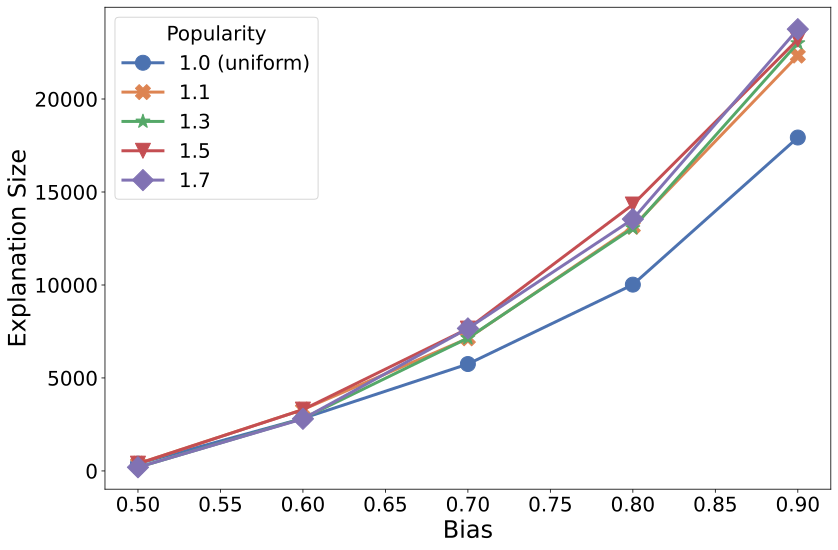

In [16]:
output_dir = './plots/full/group_group/exp0'
output_filename = 'exp0_s_bias_expl_males'
output_format = 'pdf'

markers = ['o', 'X', '*', 'v', 'D']
colors = sns.color_palette('deep')

bias = np.array([0.5, 0.5, 0.5, 0.5, 0.5,
                 0.6, 0.6, 0.6, 0.6, 0.6,
                 0.7, 0.7, 0.7, 0.7, 0.7,
                 0.8, 0.8, 0.8, 0.8, 0.8,
                 0.9, 0.9, 0.9, 0.9, 0.9])
popularity = np.array([1.1, 1.3, 1.5, 1.7, 1.0,
                       1.1, 1.3, 1.5, 1.7, 1.0,
                       1.1, 1.3, 1.5, 1.7, 1.0,
                       1.1, 1.3, 1.5, 1.7, 1.0,
                       1.1, 1.3, 1.5, 1.7, 1.0])
expl_size = np.array([393, 194, 389, 195, 391,
                      3300, 2821, 3296, 2802, 2826,
                      7130, 7144, 7653, 7664, 5748,
                      13127, 13059, 14328, 13542, 10018,
                      22336, 23006, 23203, 23758, 17930])

# Plot bias
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)

un_pop = np.unique(popularity)
for i in range(un_pop.shape[0]):
    inds = np.where(popularity == un_pop[i])[0]
    
    ax.plot(bias[inds],
            expl_size[inds],
            label=f"{str(un_pop[i]) + ' (uniform)' if un_pop[i] == 1 else str(un_pop[i])}",
            color=colors[i],
            marker=markers[i])
    
ax.set_xlabel('Bias')
ax.set_ylabel(r'Explanation Size')

ax.legend(title='Popularity')

plt.tight_layout()
plt.savefig(f'{output_dir}/{output_filename}.{output_format}')

## Experiment 1 and 2

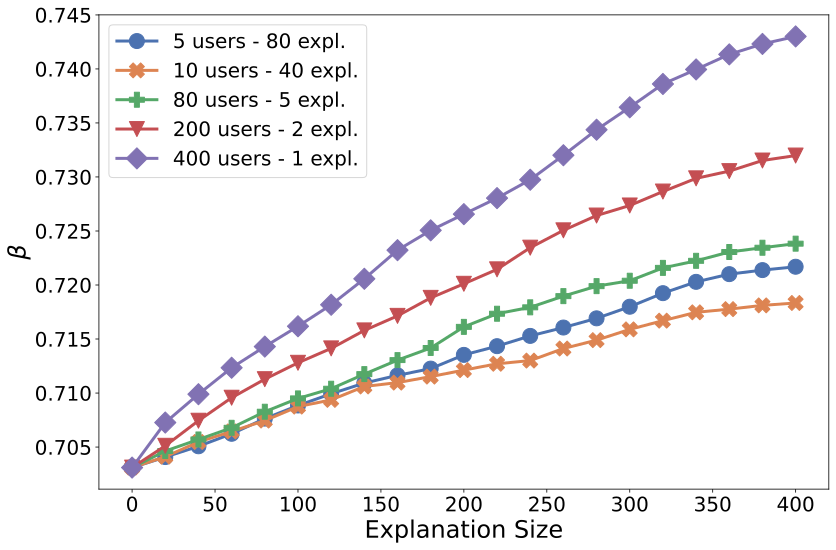

In [69]:
exp_dir = './output/full/group_group/exp1'
exp_filenames = ['exp1_5_80_males_20',
                 'exp1_10_40_males_20',
#                  'exp1_20_20_males_20',
#                  'exp1_40_10_males_20',
                 'exp1_80_5_males_20',
                 'exp1_200_2_males_20',
                 'exp1_400_1_males_20']
output_dir = './plots/full/group_group/exp1'
output_filename = 'exp1_400_males'

# markers = ['o', 'X', '*', '|', 'P', 'v', 'D']
markers = ['o', 'X', 'P', 'v', 'D']

calculate_increase = False
output_format = 'png'
item_group = 1

# Pick seaborn color palette
colors = sns.color_palette('deep')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)
for filename_ind in range(len(exp_filenames)):
    with open(f'{exp_dir}/{exp_filenames[filename_ind]}.tsv') as f:
        for i in range(6): f.readline() # Skip header lines
            
        lines = f.readlines()
        
        sample_size, k_nbs, nbs_per_round = int(lines[0].split()[0]),int(lines[0].split()[1]),int(lines[0].split()[2])
        ppr_0 = np.array([float(v) for v in lines[1].split()])
        ppr_1 = np.array([float(v) for v in lines[2].split()])
        item_ids = np.array([int(v) for v in lines[3].split()])
        user_ids = np.array([int(v) for v in lines[4].split()])
    
    numerator, denominator = (ppr_0, ppr_1) if item_group == 0 else (ppr_1, ppr_0)
    
    if calculate_increase:
        y_values = ((numerator/denominator) - (numerator[0]/denominator[0]))/(numerator[0]/denominator[0])
    else:
        y_values = numerator/denominator

    # Plot PPR scores
    ax.plot(np.arange(len(y_values))*nbs_per_round,
            y_values,
            label=f"{sample_size} users - {k_nbs} expl.",
            color=colors[filename_ind],
            marker=markers[filename_ind])

if calculate_increase:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

ax.set_xlabel("Explanation Size")
ax.set_ylabel(r"Relative $\beta$ Increase" if calculate_increase else r"$\beta$")
ax.legend()
plt.tight_layout()

plt.savefig(f"{output_dir}/{output_filename}.{output_format}")

## Experiment 3 (modified)

Study properties of items deleted, using files from experiment 1.

10


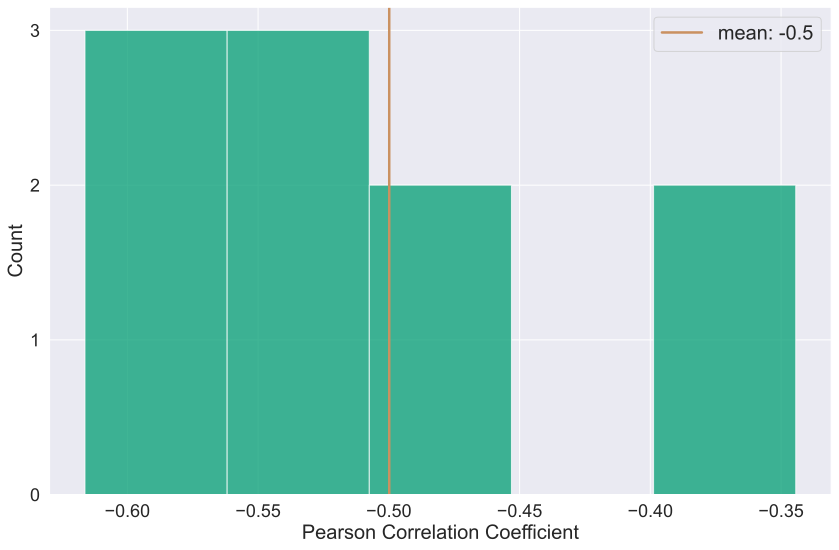

In [5]:
exp_dir = './output/full/group_group/exp3'
# exp_filename = 'exp3_20_20_males_deltas'
# exp_filename = 'exp3_40_10_males_deltas'
exp_filename = 'exp3_10_40_males_deltas'
output_dir = './plots/full/group_group/exp3'

colors = sns.color_palette('colorblind')
output_format = 'pdf'

item_group = 1

with open(f'{exp_dir}/{exp_filename}.tsv') as f:
    for i in range(6): f.readline() # Skip header lines

    lines = f.readlines()

    sample_size, k_nbs = int(lines[0].split()[0]), int(lines[0].split()[1])
    deltas_0 = np.array([float(v) for v in lines[1].split()])
    deltas_1 = np.array([float(v) for v in lines[2].split()])
    item_ids = np.array([int(v) for v in lines[3].split()])
    user_ids = np.array([int(v) for v in lines[4].split()])

cur_deltas = deltas_0 if item_group == 0 else deltas_1

user_ids_un = np.unique(user_ids)
correlations = []
for u in user_ids_un:
    u_inds = np.where(user_ids == u)[0]
    
    pearson_res = pearsonr(cur_deltas[u_inds],
                           [np.count_nonzero(R[:, np.where(item_original_ids == i)[0][0]])/R.shape[0]
                            for i in item_ids[u_inds]])
    
    if pearson_res.pvalue > 0.05: continue
        
    correlations.append(pearson_res.statistic)
print(len(correlations))
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)
ax.hist(correlations,
        bins='auto',
        color=colors[2],
        alpha=0.75)

# Plot a vertical line on the mean
ax.axvline(x=np.mean(np.array(correlations)),
           ymin=0,
           ymax=20,
           label=f"mean: {round(np.mean(np.array(correlations)), 3)}",
           color=colors[5],
           linewidth=2.5)

ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

ax.set_xlabel("Pearson Correlation Coefficient")
ax.set_ylabel("Count")
ax.legend()
plt.tight_layout()

plt.savefig(f"{output_dir}/{exp_filename}_delta_pop_co.{output_format}")

## Experiment 3 - Real and synthetic: Study the properties of items deleted

C:\Users\Λεωνίδας\AppData\Local\Temp\ipykernel_4148\3801981384.py:216: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


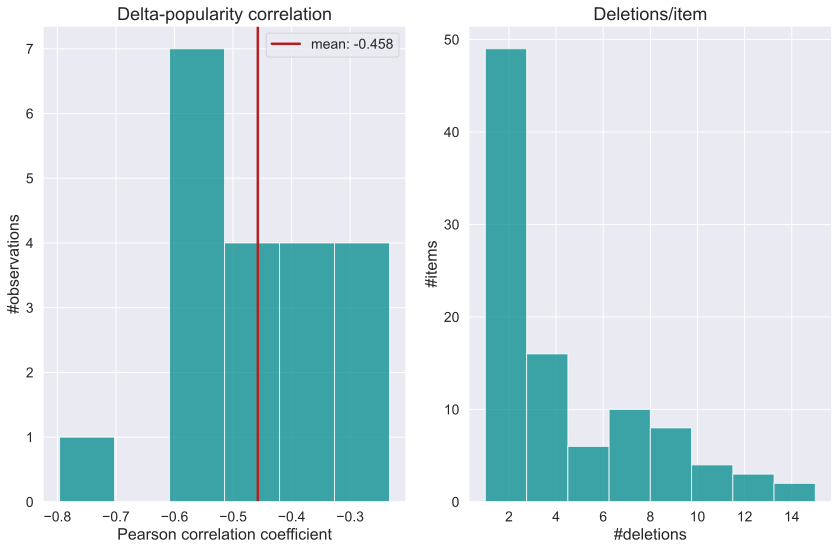

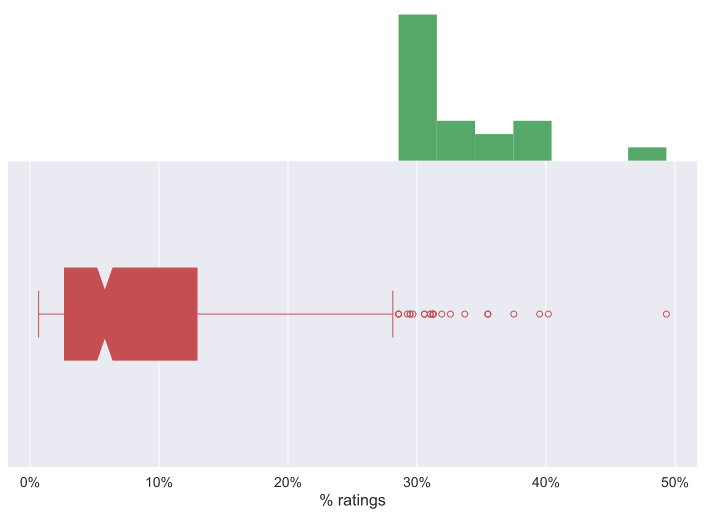

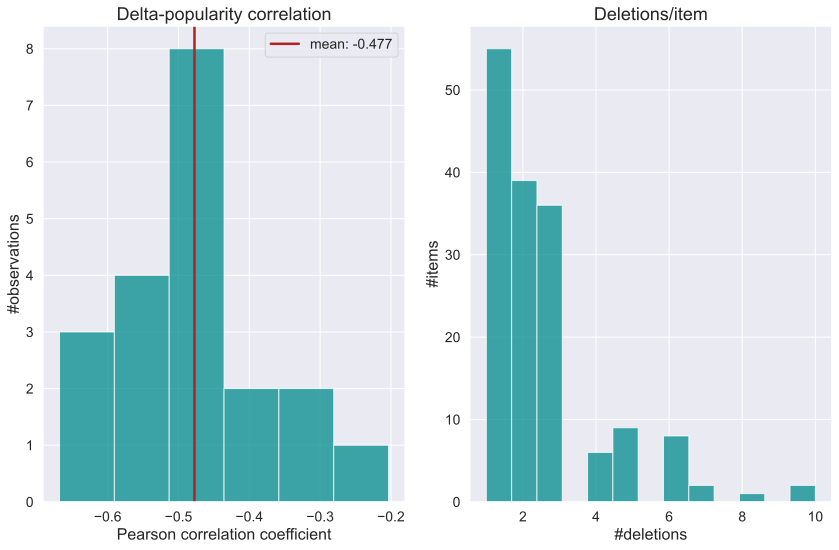

In [10]:
############ Parameters
experiments_dir = './output/group/experiment3'
experiment_filenames = ['experiment3_r_males_20_20',
                        'experiment3_s_males_2_2_20_20']
# experiment_filenames = ['experiment3_r_males_400_1',
#                         'experiment3_s_males_2_2_400_1']
synthetic_dataset_dir = '../datasets/synthetic'

output_dir = './plots/group/experiment3'
output_filename = 'experiment_3'
# output_format = 'png'
output_format = 'pdf'

filter_out = True
filter_out_genre = 'Romance'

genres_str = ['Action', 'Romance']
colors = sns.color_palette('deep')
############

for file_ind in range(len(experiment_filenames)):
    dataset_type = experiment_filenames[file_ind].split('_')[1]
    sample_from_user_group = True if experiment_filenames[file_ind].split('_')[2] == 'males' else False
    
    # Load dataset
    if dataset_type == 'r':
        my_dataset = UserItemDataset()
        my_dataset.load_data(info_filepath='../datasets/ml-100k/u.info',
                             users_filepath='../datasets/ml-100k/u.user',
                             items_filepath='../datasets/ml-100k/u.item',
                             genres_filepath='../datasets/ml-100k/u.genre',
                             ratings_filepath='../datasets/ml-100k/u.data')
        user_original_ids, item_original_ids, R = my_dataset.filter_interactions_by_genre(genres_str,
                                                                                          exclusive=True)
        # Define subplot positioning
        subplot_pos = [121, 122]
    else:
        bias_ind = experiment_filenames[file_ind].split('_')[-4]
        popularity_ind = experiment_filenames[file_ind].split('_')[-3]
        dataset_filename = f"synthetic_{bias_ind}_{popularity_ind}.tsv"
        
        # Read dataset from file
        dataset_metadata, R = read_synthetic_dataset_from_file(os.path.join(synthetic_dataset_dir, dataset_filename))
        
        users_num, items_num = dataset_metadata['num_users'], dataset_metadata['num_items']
        num_users_0 = round(dataset_metadata['r_u']*users_num)
        num_items_0 = round(dataset_metadata['r_i']*items_num)
        user_ids_U_0 = np.arange(num_users_0)
        item_ids_I_0 = np.arange(num_items_0)

        my_dataset = UserItemDataset()
        my_dataset.load_synthetic_data(R,
                                       user_ids_U_0,
                                       item_ids_I_0,
                                       genres_str)

        user_original_ids, item_original_ids = np.arange(users_num), np.arange(items_num)
        
        # Define subplot positioning
        subplot_pos = [121, 122]

    # Read experiment file
    sample_user_original_ids = []
    delta_scores = []
    neighbor_original_ids = []
    with open(f"{experiments_dir}/{experiment_filenames[file_ind]}.tsv") as f:
        # Skip header line
        f.readline()
        
        # Read experiment info
        info_line = f.readline()
        sample_size = int(info_line.split()[0])
        num_best_neighbors = int(info_line.split()[1])
        
        sample_user_original_ids = [int(v) for v in f.readline().split()]
        
        # Neighbors and deltas are stored in sequence along with users, i.e. first num_best_neighbors is for first user, etc
        delta_line = [float(v) for v in f.readline().split()]
        neighbors_line = [int(v) for v in f.readline().split()]
        for i in range(sample_size):
            delta_scores.append(delta_line[i*num_best_neighbors:(i+1)*num_best_neighbors])
            neighbor_original_ids.append(neighbors_line[i*num_best_neighbors:(i+1)*num_best_neighbors])
        
    # Filter out
    if filter_out:
        item_inds_to_remove = []
        for i in range(len(neighbor_original_ids)):
            for j in range(len(neighbor_original_ids[i])):
                if my_dataset.is_genre(neighbor_original_ids[i][j], filter_out_genre):
                    item_inds_to_remove.append(j)
        
            # Remove filter_out_genre items
            for item_ind in item_inds_to_remove[::-1]:
                del neighbor_original_ids[i][item_ind]
                del delta_scores[i][item_ind]
            
    # Calculate popularities
    popularities = []
    for i in range(len(neighbor_original_ids)):
        popularities_cur = []
        for j in range(len(neighbor_original_ids[i])):
            neighbor_mapped_id = np.where(item_original_ids == neighbor_original_ids[i][j])[0]
            popularities_cur.append(np.count_nonzero(R[:, neighbor_mapped_id])/R.shape[0])
        popularities.append(popularities_cur)
        
    # Calculate pearson correlation per user
    correlation_coef = []
    for i in range(len(sample_user_original_ids)):
        pearson_res = pearsonr(delta_scores[i],
                               popularities[i])
        # Skip nan values
        if np.isnan(pearson_res.statistic):
            continue
        
        correlation_coef.append(pearson_res.statistic)
        
    ###### Make plots
    fig = plt.figure(figsize=(12,8), dpi=120)
    if output_format != 'pdf':
        fig.suptitle(f"Group-level - Experiment 3 ({'Real' if dataset_type == 'r' else 'Synthetic'} dataset)\n" + 
                     f"(Users: {'only males' if sample_from_user_group else 'both genders'})")
    
    #### PLOT 1: 
    ax = fig.add_subplot(subplot_pos[0])
    
    ax.hist(correlation_coef,
            bins='auto',
            color='darkcyan',
            alpha=0.75)
    
    # Plot a vertical line on the mean
    ax.axvline(x=np.mean(np.array(correlation_coef)),
               ymin=0,
               ymax=20,
               label=f"mean: {round(np.mean(np.array(correlation_coef)), 3)}",
               color='firebrick',
               linewidth=2.5)
    
    ax.set_title("Delta-popularity correlation")
    ax.set_xlabel("Pearson correlation coefficient")
    ax.set_ylabel("#observations")
    ax.legend()
    
    #### PLOT 2: Number of times an item deleted
    un_neighbors, neighbor_cnts = np.unique(np.array(neighbor_original_ids), return_counts=True)
    counters_dict = dict(zip(un_neighbors, neighbor_cnts))
    
    ax = fig.add_subplot(subplot_pos[1])
    ax.hist(neighbor_cnts,
            bins='auto',
            color='darkcyan',
            alpha=0.75)
    
    ax.set_title("Deletions/item")
    ax.set_xlabel('#deletions')
    ax.set_ylabel('#items')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{output_filename}_{'_'.join(experiment_filenames[file_ind].split('_')[1:])}.{output_format}")
    
    if dataset_type == 'r':
        # Calculate number of total ratings for users in sample
        user_ratings_ratio = []
        sample_ratings_ratio = []
        for i in range(user_original_ids.shape[0]):
            if sample_from_user_group:
                # Keep only males in population
                if my_dataset.is_male(user_original_ids[i]):
                    user_ratings_ratio.append(np.count_nonzero(R[i, :])/R.shape[1])

                    # Keep sample users ratio in a seperate list, too
                    if user_original_ids[i] in sample_user_original_ids:
                        sample_ratings_ratio.append(np.count_nonzero(R[i, :])/R.shape[1])
            else:
                user_ratings_ratio.append(np.count_nonzero(R[i, :])/R.shape[1])

                # Keep sample users ratio in a seperate list, too
                if user_original_ids[i] in sample_user_original_ids:
                    sample_ratings_ratio.append(np.count_nonzero(R[i, :])/R.shape[1])
                    
        
        fig = plt.figure(figsize=(12,8), dpi=120)
        gs = fig.add_gridspec(2, 1, height_ratios=(1, 2),
                      left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0)
        
        #### PLOT 3: Box plot for users ratings
#         ax = fig.add_subplot(subplot_pos[3])
        ax_box = fig.add_subplot(gs[1, 0])
        temp_bp = ax_box.boxplot(user_ratings_ratio,
                                 patch_artist=True,
                                 notch=True,
                                 widths=0.3,
                                 vert=False,
                                 flierprops=dict(markeredgecolor=colors[3]))

        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(temp_bp[element], color=colors[3])
        temp_bp['boxes'][0].set(facecolor=colors[3])
        
#         ax.set_title("User ratings ratio (population distribution)")
        ax_box.set_yticks([])
        ax_box.set_xlabel("% ratings")
        ax_box.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
        
        #### PLOT 4: Ratio of ratings for sample users
#         ax = fig.add_subplot(subplot_pos[2])
        with plt.style.context('default'):
            ax_hist = fig.add_subplot(gs[0, 0], sharex=ax_box)
            ax_hist.hist(sample_ratings_ratio,
                         bins='auto',
                         color=colors[2])
            ax_hist.set_yticks([])
            ax_hist.tick_params(axis="x", labelbottom=False)
            ax_hist.axis('off')

        plt.tight_layout()
        plt.savefig(f"{output_dir}/first_try_{experiment_filenames[file_ind].split('_')[-2:]}.{output_format}")

#         ax.set_title("User ratings ratio (sample distribution)")
#         ax.set_xlabel("% ratings")
#         ax.set_ylabel("#users")
#         ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    
#     plt.tight_layout()
#     plt.savefig(f"{output_dir}/{output_filename}_{'_'.join(experiment_filenames[file_ind].split('_')[1:])}.{output_format}")

## Experiment 4

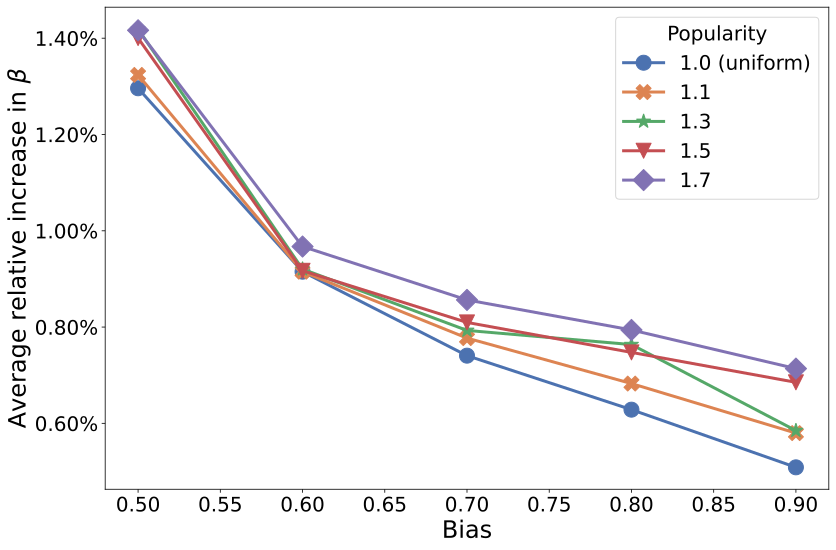

In [109]:
exp_dir = './output/full/group_group/exp4'
output_dir = './plots/full/group_group/exp4'
output_filename = 'exp4_s_avg_increase_20_20'
output_format = 'pdf'

item_group = 1

markers = ['o', 'X', '*', 'v', 'D']
colors = sns.color_palette('deep')

bias, popularity, y_values = [], [], []
for filename in os.listdir(exp_dir):
    cur_b, cur_p = float(filename.split('_')[4]), float(filename.split('_')[6])
    bias, popularity = bias + [cur_b], popularity + [cur_p]
    
    with open(os.path.join(exp_dir, filename)) as f:
        for i in range(6): f.readline() # Skip header lines
        f.readline() # Skip
            
        p_U_0_I_0 = np.array([float(v) for v in f.readline().split()])
        p_U_0_I_1 = np.array([float(v) for v in f.readline().split()])
        
    num, denom = (p_U_0_I_0, p_U_0_I_1) if item_group == 0 else (p_U_0_I_1, p_U_0_I_0)
    beta = num/denom
    
    y_values += [np.mean((beta[-1] - beta[0])/beta[0])]

bias, popularity, y_values = np.array(bias), np.array(popularity), np.array(y_values)

# Plot bias
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)

un_pop = np.unique(popularity)
for i in range(un_pop.shape[0]):
    inds = np.where(popularity == un_pop[i])[0]
    
    ax.plot(bias[inds],
            y_values[inds],
            label=f"{str(un_pop[i]) + ' (uniform)' if un_pop[i] == 1 else str(un_pop[i])}",
            color=colors[i],
            marker=markers[i])

ax.set_xlabel('Bias')
ax.set_ylabel(r'Average relative increase in $\beta$')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.legend(title='Popularity')

plt.tight_layout()
plt.savefig(f'{output_dir}/{output_filename}.{output_format}')

#### Create bias and popularity plots (functions reused from before)

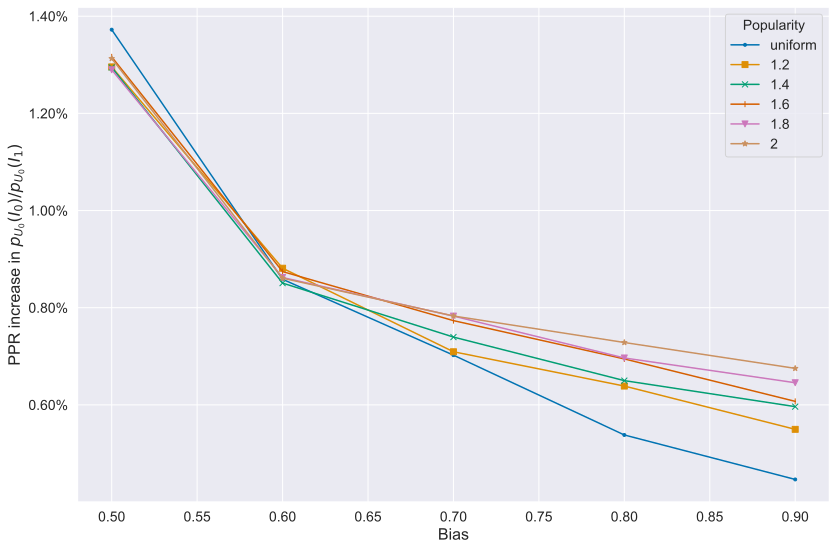

In [14]:
##### PLOT 1: Bias plot
output_path = './plots/group/experiment4'
output_filename = f"exp4_bias_{num_users}_{num_neighbors}_{'increase' if calculate_increase else 'final'}"

plot_params_dict = {
    'suptitle': "Group-level - Experiment 4 (Synthetic data)",
    'title'   : r"$U_{0}$ = Male, $I_{0}$ = Romance" +
                   f", Sample size={num_users} " +
                   r"(greatest $p_{U_0}(u)$)" +
                   f", Neighbors removed={num_neighbors}/user",
    'ylabel'  : f"PPR {'increase in' if calculate_increase else 'final'} " + r"$p_{U_0}(I_0)/p_{U_0}(I_1)$"    
}

create_bias_plot(bias_values=bias_values,
                 popularity_values=popularity_values,
                 ppr_increase_arr=ppr_arr,
                 output_path=output_path,
                 output_filename=output_filename,
                 in_percentage=True,
                 plot_params_dict=plot_params_dict,
                 output_format='pdf')
                 #output_format='png')

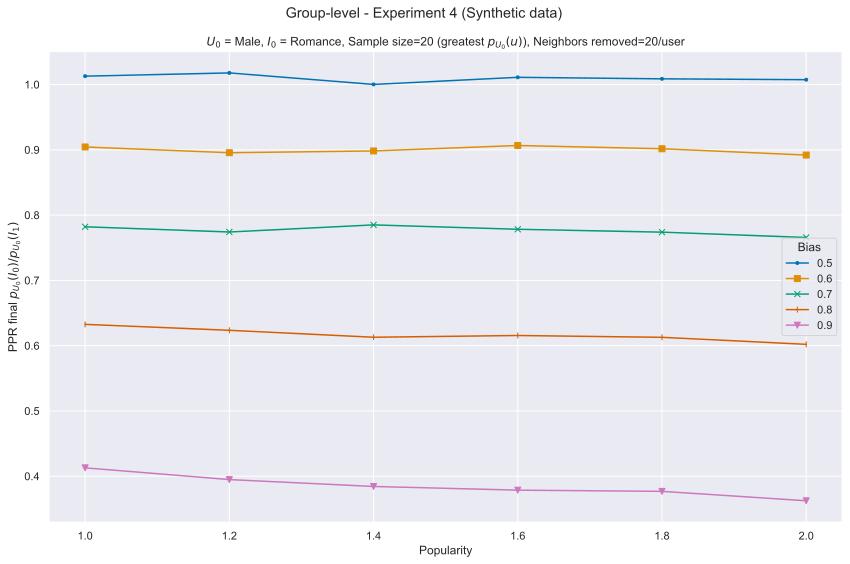

In [44]:
##### PLOT 2: Popularity plot
output_path = './plots/group/experiment4'
output_filename = f"exp4_popularity_{num_users}_{num_neighbors}_{'increase' if calculate_increase else 'final'}"

plot_params_dict = {
    'suptitle': "Group-level - Experiment 4 (Synthetic data)",
    'title'   : r"$U_{0}$ = Male, $I_{0}$ = Romance" +
                   f", Sample size={num_users} " +
                   r"(greatest $p_{U_0}(u)$)" +
                   f", Neighbors removed={num_neighbors}/user",
    'ylabel'  : f"PPR {'increase in' if calculate_increase else 'final'} " + r"$p_{U_0}(I_0)/p_{U_0}(I_1)$"   
}

create_popularity_plot(bias_values=bias_values,
                       popularity_values=popularity_values,
                       ppr_increase_arr=ppr_arr,
                       output_path=output_path,
                       output_filename=output_filename,
                       in_percentage=True,
                       plot_params_dict=plot_params_dict,
                       output_format='png')

### For experiment 4, plot only the average ratio increase for users in sample

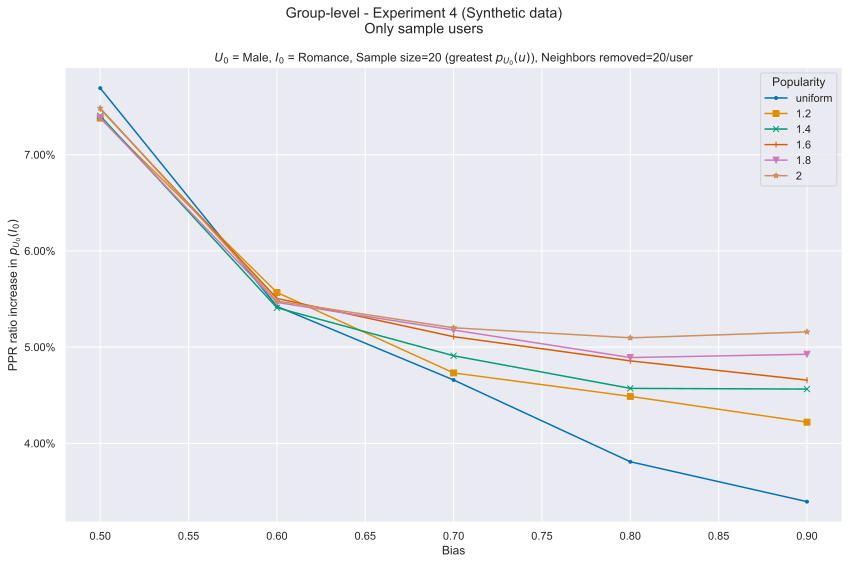

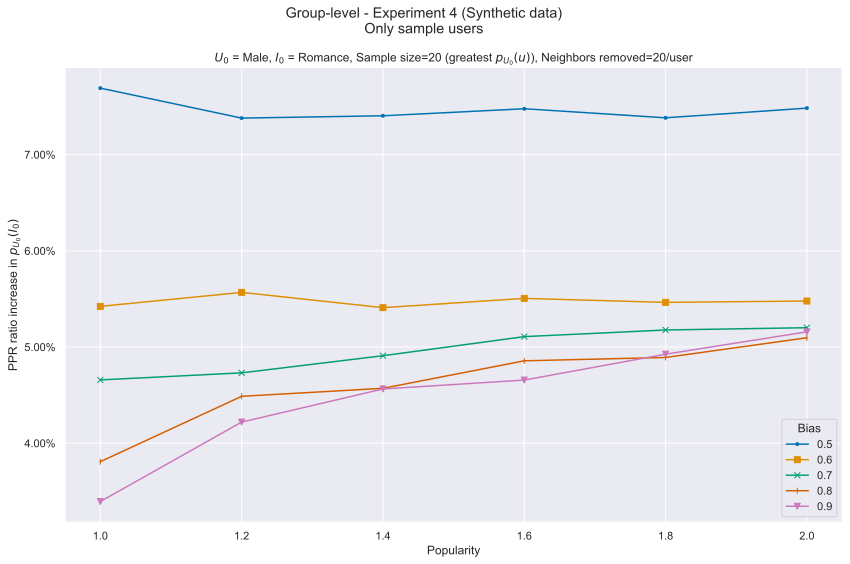

In [94]:
experiment_dir = './output/group/experiment4'
filenames = os.listdir(experiment_dir)

# Calculate y-axis increase in percentage or values
# If true, results are in decimal format (e.g. 0.04 is 4%)
in_percentage = True

# Parameters used to create these files
bias_values = [0.5, 0.6, 0.7, 0.8, 0.9]
popularity_values = [1, 1.2, 1.4, 1.6, 1.8, 2]

num_users = 20
num_neighbors = 20

absorbing_col = 1

# Create array to store PPR increase
# Explanation: The ixj cell has the PPR increase for a synthetic dataset
#              created with bias_values[i] and popularity_values[j]
ppr_increase_arr = np.zeros((len(bias_values), len(popularity_values)), dtype=float)

for filename in filenames:
    with open(f"{experiment_dir}/{filename}") as f:
        cur_bias_ind = int(filename.split('_')[-4])
        cur_popularity_ind = int(filename.split('_')[-3])
        
        # Skip meta lines
        for i in range(9):
            f.readline()
        
        # Read sample ids
        sample_ids = np.array([int(v) for v in f.readline().split()])
        
        # Skip header
        f.readline()
        
        # Read initial category scores and keep only the scores of sample_ids
        scores_initial_0 = np.array([float(v) for v in f.readline().split()])[sample_ids]
        scores_initial_1 = np.array([float(v) for v in f.readline().split()])[sample_ids]
        
        # Skip header
        f.readline()
        
        # Read final category scores
        scores_final_0 = np.array([float(v) for v in f.readline().split()])[sample_ids]
        scores_final_1 = np.array([float(v) for v in f.readline().split()])[sample_ids]
        
    # Calculate ratios
    if absorbing_col == 0:
        numerator_initial = scores_initial_0
        numerator_final = scores_final_0
    else:
        numerator_initial = scores_initial_1
        numerator_final = scores_final_1
    
    avg_ratio_increase_sum = 0
    for i in range(sample_ids.shape[0]):
        initial_ratio_cur = numerator_initial[i]/(scores_initial_0[i] + scores_initial_1[i])
        final_ratio_cur = numerator_final[i]/(scores_final_0[i] + scores_final_1[i])
        
        avg_ratio_increase_sum += (final_ratio_cur - initial_ratio_cur)/initial_ratio_cur
    
    avg_ratio_increase_sum /= sample_ids.shape[0]
    
    # Store result
    ppr_increase_arr[cur_bias_ind][cur_popularity_ind] = avg_ratio_increase_sum
    
# Plot results
output_path = './plots/group/experiment4'

##### PLOT 1: Bias plot
output_filename = f'experiment4_bias_to_ppr_{num_users}_{num_neighbors}_sample'
plot_params_dict = {
    'suptitle': "Group-level - Experiment 4 (Synthetic data)\nOnly sample users",
    'title'   : r"$U_{0}$ = Male, $I_{0}$ = Romance" +
                   f", Sample size={num_users} " +
                   r"(greatest $p_{U_0}(u)$)" +
                   f", Neighbors removed={num_neighbors}/user",
    'ylabel'  : r"PPR ratio increase in $p_{U_0}(I_0)$"    
}
create_bias_plot(bias_values=bias_values,
                 popularity_values=popularity_values,
                 ppr_increase_arr=ppr_increase_arr,
                 output_path=output_path,
                 output_filename=output_filename,
                 in_percentage=in_percentage,
                 plot_params_dict=plot_params_dict,
                 output_format='png')

##### PLOT 2: Popularity plot
output_filename = f'experiment4_popularity_to_ppr_{num_users}_{num_neighbors}_sample'
plot_params_dict = {
    'suptitle': "Group-level - Experiment 4 (Synthetic data)\nOnly sample users",
    'title'   : r"$U_{0}$ = Male, $I_{0}$ = Romance" +
                   f", Sample size={num_users} " +
                   r"(greatest $p_{U_0}(u)$)" +
                   f", Neighbors removed={num_neighbors}/user",
    'ylabel'  : r"PPR ratio increase in $p_{U_0}(I_0)$"    
}
create_popularity_plot(bias_values=bias_values,
                       popularity_values=popularity_values,
                       ppr_increase_arr=ppr_increase_arr,
                       output_path=output_path,
                       output_filename=output_filename,
                       in_percentage=in_percentage,
                       plot_params_dict=plot_params_dict,
                       output_format='png')

## Experiment 5 - Correlations

In [31]:
exp_dir = './output/full/group_group/exp5'
# exp_filename = 'exp5_50_male_rom_avg_delta'
exp_filename = 'exp5_50_male_rom_sum_delta'
# output_dir = './plots/full/group_group/exp5'
# output_format = 'pdf'

colors = sns.color_palette('deep')

with open(f"{exp_dir}/{exp_filename}.tsv") as f:
    for i in range(4): f.readline() # Skip header lines

    lines = f.readlines()
    p_U_0_I_0 = np.array([float(v) for v in lines[0].split()])
    p_U_0_I_1 = np.array([float(v) for v in lines[1].split()])
    item_ids = np.array([int(v) for v in lines[2].split()])
    
P = create_recwalk_model(R) # Create transition prob. matrix
Q = calculate_matrix_Q(P)
ppr_u_to_i = Q[:users_num, users_num:]

item_degrees_U_0, item_degrees_U_1 = [], []
for i_id in item_ids:
    i_mapped_id = np.where(item_original_ids == i_id)[0][0]
    item_degrees_U_0.append(np.count_nonzero(R[male_mapped_ids, i_mapped_id]))
    item_degrees_U_1.append(np.count_nonzero(R[female_mapped_ids, i_mapped_id]))
    
print('#### Experiment 5 (removing items) ####')
pearson_res = pearsonr(np.arange(item_ids.shape[0]),
                       item_degrees_U_0)
print(f"> item degree in U_0 - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")

pearson_res = pearsonr(np.arange(item_ids.shape[0]),
                       item_degrees_U_1)
print(f"> item degree in U_1 - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")

pearson_res = pearsonr(np.arange(item_ids.shape[0]),
                       np.array(item_degrees_U_0) + np.array(item_degrees_U_1))
print(f"> item degree overall - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")
print('-----') #-----------------------#
p_U_0_i_all = np.array([np.mean(ppr_u_to_i[male_mapped_ids, np.where(item_original_ids == i_id)[0][0]])
                         for i_id in item_ids])
pearson_res = pearsonr(np.arange(item_ids.shape[0]),
                       p_U_0_i_all)
print(f"> item bias from U_0 - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")

p_U_1_i_all = np.array([np.mean(ppr_u_to_i[female_mapped_ids, np.where(item_original_ids == i_id)[0][0]])
                         for i_id in item_ids])
pearson_res = pearsonr(np.arange(item_ids.shape[0]),
                       p_U_1_i_all)
print(f"> item bias from U_1 - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")

#### Experiment 5 (removing items) ####
> item degree in U_0 - rank:
	-0.8371109803806668 (3.6082039884450363e-14)
> item degree in U_1 - rank:
	-0.8315957739439952 (7.511615863444851e-14)
> item degree overall - rank:
	-0.8580189609351262 (1.7109277540254842e-15)
-----
> item bias from U_0 - rank:
	-0.9016259333842471 (4.2676731597666797e-19)
> item bias from U_1 - rank:
	-0.8273578697420688 (1.2963883339871463e-13)


## Experiment 6 - Correlations

#### Experiment 6 (removing edges) ####
> user degree in I_1 - rank:
	0.7821519913594277 (0.0)
> user degree in I_0 - rank:
	0.4622010736759007 (2.076651588667819e-106)
> user degree overall - rank:
	0.5873769349657443 (7.935834410769842e-186)
-----
> user PR from U_0 - rank:
	0.578884437584087 (2.614869038557176e-179)
-----
> item degree in U_0 - rank:
	-0.04591171383044233 (0.04006935557095585)
> item degree in U_1 - rank:
	-0.09958139907373309 (8.130247544281995e-06)
> item degree overall - rank:
	-0.06148424567335757 (0.005949667598090618)
-----
> user bias - rank:
	-0.18063831866408805 (3.9399856113411644e-16)
-----
319
148
[0.45705196182396607, 0.43796394485683987, 0.2545068928950159, 0.22375397667020147, 0.3870625662778367, 0.44538706256627786, 0.2545068928950159, 0.1855779427359491, 0.45493107104984093, 0.40084835630965004, 0.3213149522799576, 0.14422057264050903, 0.15164369034994699, 0.3647932131495228, 0.21314952279957583, 0.13149522799575822, 0.3107104984093319, 0.2364793213

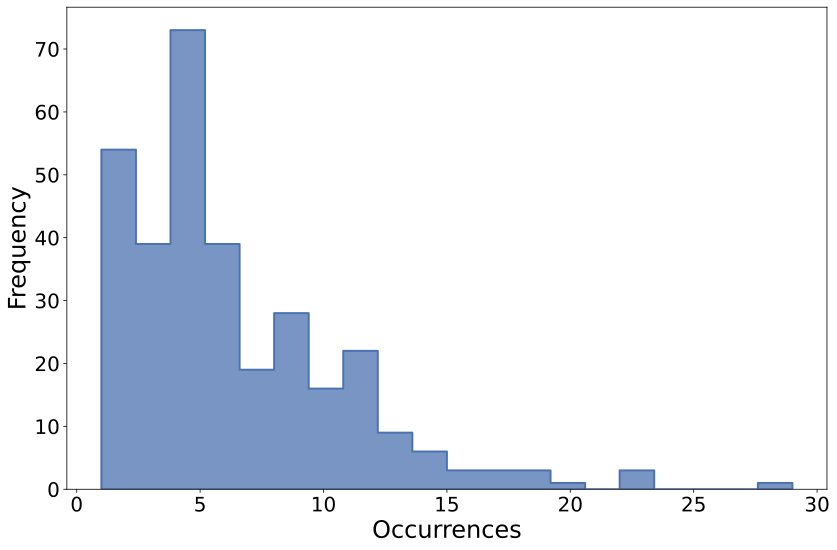

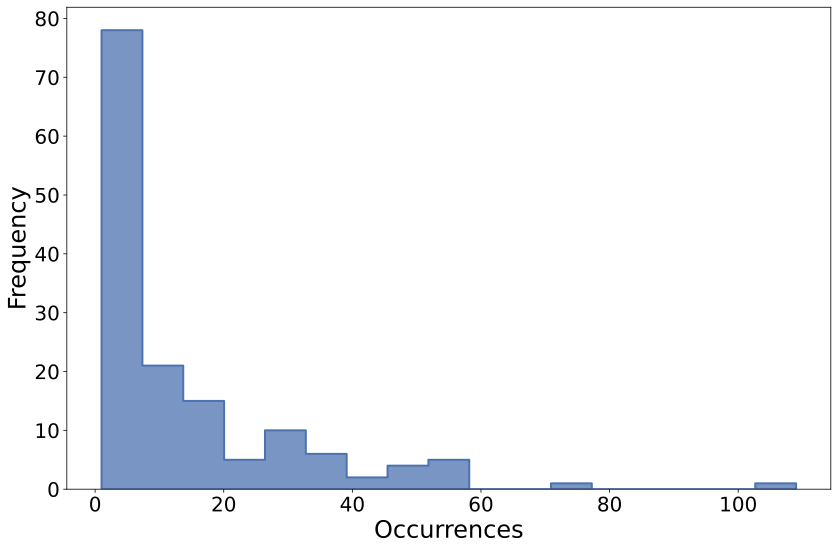

In [18]:
exp_dir = './output/full/group_group/exp6'
exp_filename = 'exp6_2000_20'
output_dir = './plots/full/group_group/exp6'
output_format = 'png'

colors = sns.color_palette('deep')

with open(f"{exp_dir}/{exp_filename}.tsv") as f:
    for i in range(5): f.readline() # Skip header lines

    lines = f.readlines()
    p_U_0_I_0 = np.array([float(v) for v in lines[0].split()])
    p_U_0_I_1 = np.array([float(v) for v in lines[1].split()])
    user_ids = np.array([int(v) for v in lines[2].split()])
    item_ids = np.array([int(v) for v in lines[3].split()])
    
item_mapped_ids = np.array([np.where(item_original_ids == i_id)[0][0] for i_id in item_ids])
    
P = create_recwalk_model(R) # Create transition prob. matrix
Q = calculate_matrix_Q(P)
ppr_u_to_i = Q[:users_num, users_num:]
ppr_u_to_u = Q[:users_num, :users_num]

print('#### Experiment 6 (removing edges) ####')
u_degrees_in_I_1 = np.array([np.count_nonzero(R[u_id, item_group_mapped_ids_0]) for u_id in user_ids])
pearson_res = pearsonr(np.arange(user_ids.shape[0]),
                       u_degrees_in_I_1)
print(f"> user degree in I_1 - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")

u_degrees_in_I_0 = np.array([np.count_nonzero(R[u_id, item_group_mapped_ids_1]) for u_id in user_ids])
pearson_res = pearsonr(np.arange(user_ids.shape[0]),
                       u_degrees_in_I_0)
print(f"> user degree in I_0 - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")

pearson_res = pearsonr(np.arange(user_ids.shape[0]),
                       u_degrees_in_I_0 + u_degrees_in_I_1)
print(f"> user degree overall - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")
print('-----') #-----------------------#
u_pr_in_U_0 = np.array([np.mean(ppr_u_to_u[male_mapped_ids, u_id]) for u_id in user_ids])
pearson_res = pearsonr(np.arange(user_ids.shape[0]),
                       u_pr_in_U_0)
print(f"> user PR from U_0 - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")

print('-----') #-----------------------#
item_degrees_U_0, item_degrees_U_1 = [], []
for i_id in item_ids:
    i_mapped_id = np.where(item_original_ids == i_id)[0][0]
    item_degrees_U_0.append(np.count_nonzero(R[male_mapped_ids, i_mapped_id]))
    item_degrees_U_1.append(np.count_nonzero(R[female_mapped_ids, i_mapped_id]))
    
pearson_res = pearsonr(np.arange(item_ids.shape[0]),
                       item_degrees_U_0)
print(f"> item degree in U_0 - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")

pearson_res = pearsonr(np.arange(item_ids.shape[0]),
                       item_degrees_U_1)
print(f"> item degree in U_1 - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")

pearson_res = pearsonr(np.arange(item_ids.shape[0]),
                       np.array(item_degrees_U_0) + np.array(item_degrees_U_1))
print(f"> item degree overall - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")
print('-----') #-----------------------#
bias_all = np.array([np.mean(ppr_u_to_i[u_id, item_group_mapped_ids_1])/np.mean(ppr_u_to_i[u_id, item_group_mapped_ids_0])
                     for u_id in user_ids])
pearson_res = pearsonr(np.arange(item_ids.shape[0]),
                       bias_all)
print(f"> user bias - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")
print('-----') #-----------------------#
un, cnts = np.unique(user_ids, return_counts=True)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)
print(un.shape[0])
# ax1.hist(cnts, bins='auto', color=colors[0], alpha=0.8)
sns.histplot(data=cnts,
                 element='step',
                 linewidth=2,
                 color=list(colors[0]) + [0.5],
                 ec=colors[0])
ax.set_xlabel('Occurrences')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig("./plots/full/group_group/exp6/edge_explain_user_occ.pdf")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)
un, cnts = np.unique(item_ids, return_counts=True)
print(un.shape[0])
# ax2.hist(cnts, bins='auto')
sns.histplot(data=cnts,
                 element='step',
                 linewidth=2,
                 color=list(colors[0]) + [0.5],
                 ec=colors[0])
ax.set_xlabel('Occurrences')
ax.set_ylabel('Frequency')

sort_inds = np.argsort(cnts)[::-1][:20]
print([np.mean(R[:, np.where(item_original_ids == un[ind])[0][0]]) for ind in sort_inds])

plt.tight_layout()
plt.savefig("./plots/full/group_group/exp6/edge_explain_item_occ.pdf")

## Experiment 7 - Correlations

In [141]:
exp_dir = './output/full/group_group/exp7'
exp_filename = 'exp7_50_males'

with open(f"{exp_dir}/{exp_filename}.tsv") as f:
    for i in range(4): f.readline() # Skip header lines

    lines = f.readlines()
    p_U_0_I_0 = np.array([float(v) for v in lines[0].split()])
    p_U_0_I_1 = np.array([float(v) for v in lines[1].split()])
    user_ids = np.array([int(v) for v in lines[2].split()])
    
print('#### Experiment 7 (removing users) ####')
u_degrees_in_I_1 = np.array([np.count_nonzero(R[u_id, item_group_mapped_ids_0]) for u_id in user_ids])
pearson_res = pearsonr(np.arange(user_ids.shape[0]),
                       u_degrees_in_I_1)
print(f"> user degree in I_1 - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")

u_degrees_in_I_0 = np.array([np.count_nonzero(R[u_id, item_group_mapped_ids_1]) for u_id in user_ids])
pearson_res = pearsonr(np.arange(user_ids.shape[0]),
                       u_degrees_in_I_0)
print(f"> user degree in I_0 - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")

pearson_res = pearsonr(np.arange(user_ids.shape[0]),
                       u_degrees_in_I_0 + u_degrees_in_I_1)
print(f"> user degree overall - rank:\n\t{pearson_res.statistic} ({pearson_res.pvalue})")

#### Experiment 7 (removing users) ####
> user degree in I_1 - rank:
	-0.9057699408247861 (1.5936628406292171e-19)
> user degree in I_0 - rank:
	-0.19833962366986674 (0.1673521753971852)
> user degree overall - rank:
	-0.6680075932405111 (1.1585136669969286e-07)


In [30]:
exp_dir = './output/full/group_group/exp5'
exp_filename = 'exp5_50_male_rom_sum_delta'

with open(f"{exp_dir}/{exp_filename}.tsv") as f:
    for i in range(6): f.readline() # Skip header lines

    exp5_item_ids = np.array([int(v) for v in f.readline().split()])
    
exp_dir = './output/full/group_group/exp6'
exp_filename = 'exp6_2000_20'

with open(f"{exp_dir}/{exp_filename}.tsv") as f:
    for i in range(7): f.readline() # Skip header lines

    exp6_user_ids = np.array([int(v) for v in f.readline().split()])
    exp6_item_ids = np.array([int(v) for v in f.readline().split()])
    
exp_dir = './output/full/group_group/exp7'
exp_filename = 'exp7_50_males'

with open(f"{exp_dir}/{exp_filename}.tsv") as f:
    for i in range(6): f.readline() # Skip header lines

    exp7_user_ids = np.array([int(v) for v in f.readline().split()])
    print(exp7_user_ids[:5])
    
print(f"exp5-exp6 common items: {np.intersect1d(exp5_item_ids[:22], exp6_item_ids[:1340]).shape[0]}")
print(f"exp7-exp6 common users: {np.intersect1d(exp7_user_ids, exp6_user_ids).shape[0]}")

print(np.nonzero(np.in1d(exp6_item_ids, exp5_item_ids))[0][:20])

top_cnt = 0
for item_id in exp5_item_ids[:22]:
    if item_id in exp6_item_ids[:100]: top_cnt += 1

print(top_cnt)

top_cnt = 0
for item_id in exp6_item_ids[:100]:
    if item_id in exp5_item_ids[:22]: top_cnt += 1
        
print(top_cnt)

# un, cnts = np.unique(exp6_user_ids, return_counts=True)
# print(un.shape[0])
# un, cnts = np.unique(exp6_item_ids, return_counts=True)
# print(un.shape[0])

[ 12 275 726 302 129]
exp5-exp6 common items: 22
exp7-exp6 common users: 0
[ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 19 20 21]
16
66


## Experiment 5, 6, 7 combined

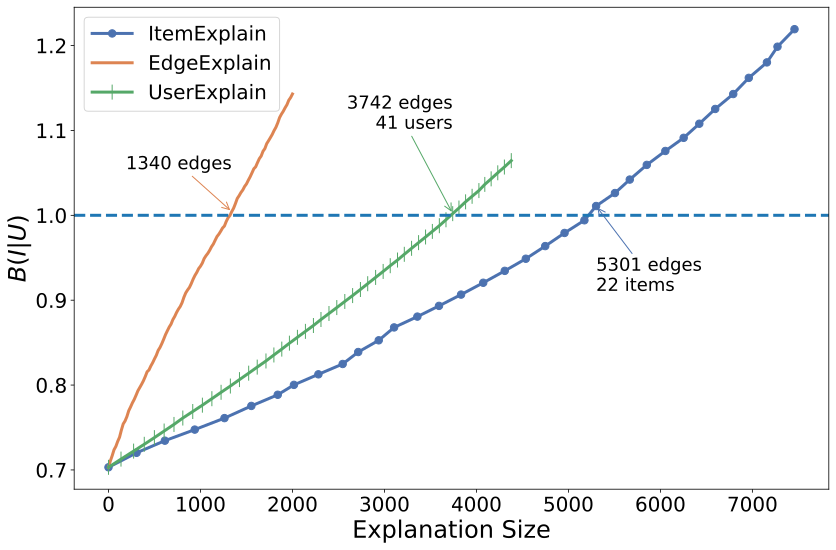

In [8]:
exp_paths = ['./output/full/group_group/exp5/exp5_50_male_rom_sum_delta',
             './output/full/group_group/exp6/exp6_2000_20',
             './output/full/group_group/exp7/exp7_50_males']
output_dir = './plots/full/group_group/exp_5_6_7_combined'
output_format = 'pdf'

colors = sns.color_palette('deep')

calculate_increase = False

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 8), dpi=120)
# READ AND PLOT EXPERIMENT 5
with open(f"{exp_paths[0]}.tsv") as f:
    for i in range(4): f.readline() # Skip header lines

    lines = f.readlines()
    p_U_0_I_0 = np.array([float(v) for v in lines[0].split()])
    p_U_0_I_1 = np.array([float(v) for v in lines[1].split()])
    item_ids = np.array([int(v) for v in lines[2].split()])

beta = p_U_0_I_0/p_U_0_I_1

y_values, fairness_value = ((beta - beta[0])/beta[0], (1 - beta[0])/beta[0]) if calculate_increase else (beta, 1)
    
fairness_ind = np.argmax(y_values >= fairness_value)
cut_ind = np.argmax(y_values > 1.2)

y_values, item_ids = y_values[:cut_ind+1], item_ids[:cut_ind]

# Calcualate num of edges removed from U_0 to cur_item_x
num_edges_removed = [0] # Start with 0 for initial score
for item_id in item_ids:
    item_mapped_id = np.where(item_original_ids == item_id)[0][0]
    num_edges_removed.append(np.count_nonzero(R[male_mapped_ids, item_mapped_id]))

num_edges_removed = np.cumsum(num_edges_removed)

ax.plot(num_edges_removed, y_values, marker='.', color=colors[0], label='ItemExplain')
ax.annotate(f"{num_edges_removed[fairness_ind]} edges\n{fairness_ind} items",
            xy=(num_edges_removed[fairness_ind], y_values[fairness_ind]),
            xytext=(num_edges_removed[fairness_ind], y_values[fairness_ind] - 0.1),
            arrowprops=dict(color=colors[0], arrowstyle="->"),
            ha='left')


# READ AND PLOT EXPERIMENT 6
with open(f"{exp_paths[1]}.tsv") as f:
    for i in range(5): f.readline() # Skip header lines

    lines = f.readlines()
    p_U_0_I_0 = np.array([float(v) for v in lines[0].split()])
    p_U_0_I_1 = np.array([float(v) for v in lines[1].split()])
    user_ids = np.array([int(v) for v in lines[2].split()])
    item_ids = np.array([int(v) for v in lines[3].split()])

beta = p_U_0_I_0/p_U_0_I_1

y_values, fairness_value = ((beta - beta[0])/beta[0], (1 - beta[0])/beta[0]) if calculate_increase else (beta, 1)
    
fairness_ind = np.argmax(y_values >= fairness_value)
edges_per_round = int(exp_paths[1].split('_')[-1])

ax.plot(np.arange(beta.shape[0])*edges_per_round, y_values, color=colors[1], label='EdgeExplain')
ax.annotate(f"{edges_per_round*fairness_ind} edges",
            xy=(fairness_ind*edges_per_round, y_values[fairness_ind]),
            xytext=(fairness_ind*edges_per_round, y_values[fairness_ind] + 0.05),
            arrowprops=dict(color=colors[1], arrowstyle="->"),
            ha='right')

# READ AND PLOT EXPERIMENT 7
with open(f"{exp_paths[2]}.tsv") as f:
    for i in range(4): f.readline() # Skip header lines

    lines = f.readlines()
    p_U_0_I_0 = np.array([float(v) for v in lines[0].split()])
    p_U_0_I_1 = np.array([float(v) for v in lines[1].split()])
    user_ids = np.array([int(v) for v in lines[2].split()])

beta = p_U_0_I_0/p_U_0_I_1

y_values, fairness_value = ((beta - beta[0])/beta[0], (1 - beta[0])/beta[0]) if calculate_increase else (beta, 1)
    
fairness_ind = np.argmax(y_values >= fairness_value)
# Calcualate num of edges removed from U_0 to I_1
num_edges_removed = [0] # Start with 0 for initial score
for user_id in user_ids:
    user_mapped_id = np.where(user_original_ids == user_id)[0][0]
    num_edges_removed.append(np.count_nonzero(R[user_mapped_id, item_group_mapped_ids_0]))

num_edges_removed = np.cumsum(num_edges_removed)
    
ax.plot(num_edges_removed, y_values, marker='|', color=colors[2], label='UserExplain')
ax.annotate(f"{num_edges_removed[fairness_ind]} edges\n{fairness_ind} users",
            xy=(num_edges_removed[fairness_ind], y_values[fairness_ind]),
            xytext=(num_edges_removed[fairness_ind], y_values[fairness_ind] + 0.1),
            arrowprops=dict(color=colors[2], arrowstyle="->"),
            ha='right')

ax.set_xlabel('Explanation Size')
ax.set_ylabel(r'$B(I|U)$')

ax.axhline(y=fairness_value,
           linestyle='dashed')

if calculate_increase:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))


ax.legend()

plt.tight_layout()
plt.savefig(f"{output_dir}/exp_5_6_7_combined.{output_format}")